In [9]:
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path.cwd().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

In [10]:
import lightning as L
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from causalflows.scms import SCM, CausalEquations

In [12]:

epochs = 1000
seed = 1324
torch.manual_seed(seed)
np.random.seed(seed)

In [13]:
from decaflow.utils.example_equations import EcoliEquations
eq = EcoliEquations(equations_type = 'additive')
graph = eq.graph
node_order = eq.node_order
scm = SCM(equations=eq, base='std-gaussian')

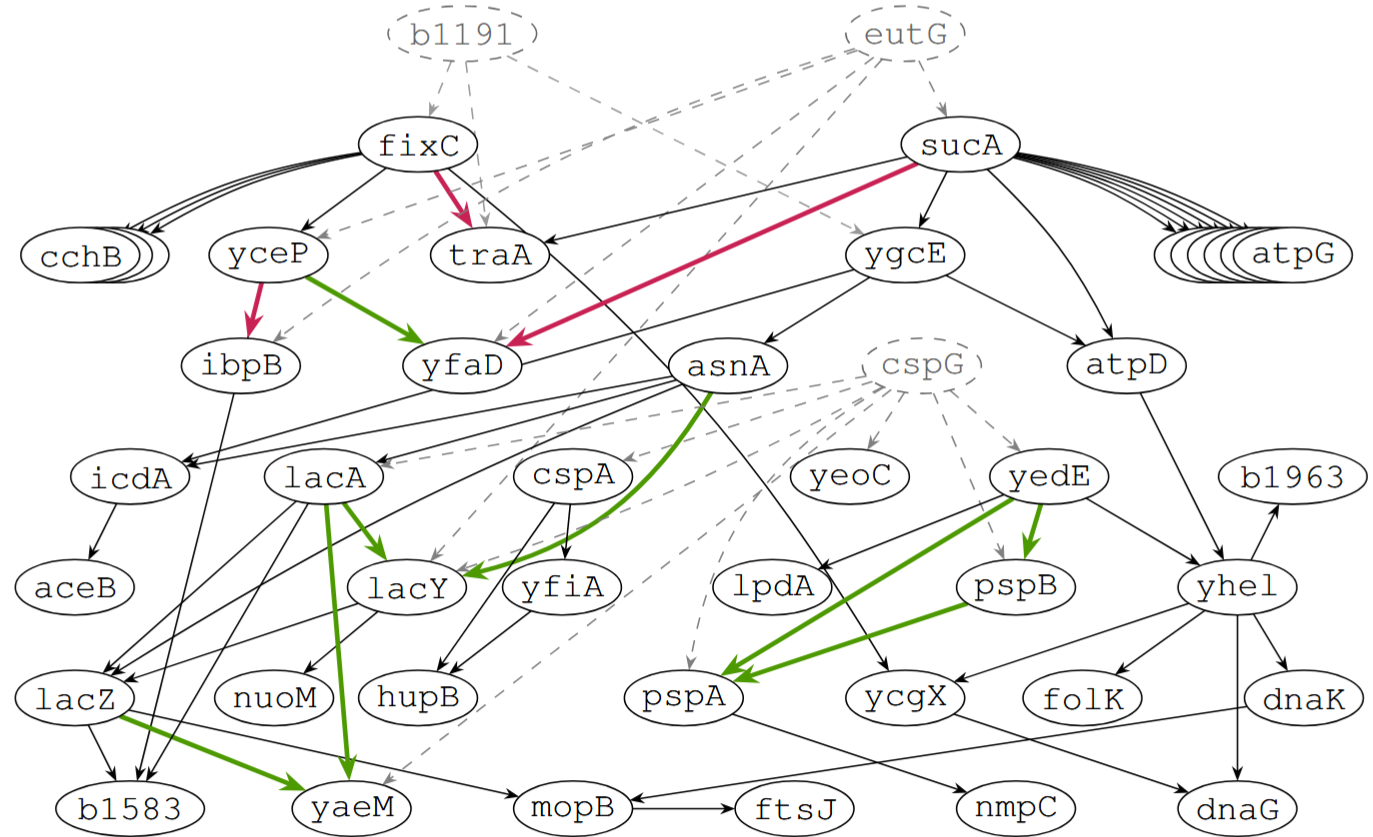

In [14]:
# insert ../assets/napkin_graph.png
from IPython.display import Image, display

display(Image(filename='../assets/ecoli_graph.png'))

In [15]:
def generate_data(size: int):
    return scm.sample((size,))
def generate_int_data(size: int, index, value):
    return scm.sample_interventional(index, value, (size,))
columns = node_order

In [16]:
x = scm.sample((1,))

In [17]:
adjacency = scm.adjacency

In [18]:
from torch.utils.data import DataLoader, TensorDataset

In [19]:
num_hidden = 3 # hidden indices = [0,1,2]
batch_size = 4096

train_size = 25000
train_data = generate_data(train_size)

test_size = int(train_size * 0.1)
test_data = generate_data(test_size)
val_data = generate_data(test_size)

# Standardize the data
mu, sigma = train_data.mean(dim=0), train_data.std(dim=0)
train_data = (train_data - mu) / sigma
test_data = (test_data - mu) / sigma
val_data = (val_data - mu) / sigma

z_train, x_train = train_data[:, :num_hidden], train_data[:, num_hidden:]
z_test, x_test = test_data[:, :num_hidden], test_data[:, num_hidden:]
z_val, x_val = val_data[:, :num_hidden], val_data[:, num_hidden:]

n_features = x_train.shape[1]

# Create the dataloaders
train_dataset = TensorDataset(x_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
all_train_loader = DataLoader(TensorDataset(train_data), batch_size, shuffle=True)

test_dataset = TensorDataset(x_test)
test_loader = DataLoader(test_dataset, batch_size=test_size)
all_test_loader = DataLoader(TensorDataset(test_data), batch_size)

val_dataset = TensorDataset(x_val)
val_loader = DataLoader(val_dataset, batch_size=test_size)
all_val_loader = DataLoader(TensorDataset(val_data), batch_size)

## Define the modules

In [20]:
from decaflow.models import Encoder, Decoder, DeCaFlow
from decaflow.utils.logger import MyLogger
from lightning.pytorch.callbacks import EarlyStopping
encoder = Encoder(flow_type='nsf', num_hidden=num_hidden,
                  adjacency=adjacency, # full adjacency
                  features=num_hidden, # models the latents
                  context=n_features, # the observed variables are conditions
                  hidden_features=[64, 64, 64],
                  activation=torch.nn.ReLU)
decoder = Decoder(flow_type='nsf', num_hidden=num_hidden,
                  adjacency=adjacency, # full adjacency
                  features=n_features, # observed variables
                  context=num_hidden, # hidden confounders as conditions
                  hidden_features=[128, 128, 128],
                  activation=torch.nn.ReLU)
unaware_decoder = Decoder(flow_type='nsf', num_hidden=0,
                    adjacency=adjacency[num_hidden:, num_hidden:], # only observed values
                    features=n_features, # does not observe the hidden confounders
                    context=0, #no hidden confounders considered
                    hidden_features=[128, 128, 128],
                    activation=torch.nn.ReLU)
oracle_decoder =  Decoder(flow_type='nsf', num_hidden=0, adjacency=adjacency,
                    features=n_features+num_hidden, # observes all the variables
                    context=0, #no hidden confounders
                    hidden_features=[128, 128, 128],
                    activation=torch.nn.ReLU)


In [21]:
scheduler_cls = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_config = {'mode': 'min', 'factor': 0.95, 'patience': 10, 'verbose': False, 'cooldown':0}


## Instance the models

In [22]:

decaflow = DeCaFlow(encoder=encoder, flow=decoder,
                    regularize=True, warmup=200,
                    lr=1e-3, optimizer_cls=torch.optim.Adam,
                    scheduler_cls=scheduler_cls,
                    scheduler_kwargs=scheduler_config,
                    scheduler_monitor='val_loss')
unaware_flow = DeCaFlow(encoder=None, flow=unaware_decoder, regularize=False,
                    lr=1e-3, optimizer_cls=torch.optim.Adam,
                    scheduler_cls=scheduler_cls,
                    scheduler_kwargs=scheduler_config,
                    scheduler_monitor='val_loss')
oracle = DeCaFlow(encoder=None, flow=oracle_decoder, regularize=False,
                  lr=1e-3, optimizer_cls=torch.optim.Adam,
                    scheduler_cls=scheduler_cls,
                    scheduler_kwargs=scheduler_config,
                    scheduler_monitor='val_loss')

Train DeCaFlow

In [ ]:
logger = MyLogger()
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,         
    patience=100,             
    verbose=False,
    mode='min'               
)
trainer = L.Trainer(callbacks=[early_stop_callback],max_epochs=epochs, logger=logger, enable_checkpointing=False, log_every_n_steps=len(train_loader)-1)
trainer.fit(decaflow, train_loader, val_loader)

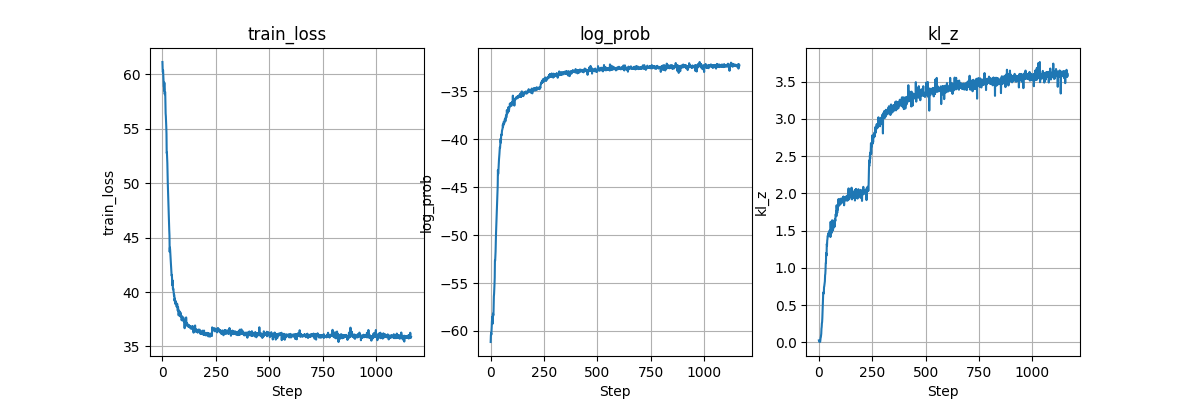

In [5]:
from decaflow.utils.plot import plot_logs
plot_logs(logger, columns=['train_loss', 'log_prob', 'kl_z'])
logger.values['train_loss'][-1], logger.values['log_prob'][-1], logger.values['kl_z'][-1]

Train the Unaware flow

In [ ]:
logger_unaware = MyLogger()
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,         
    patience=100,             
    verbose=False,
    mode='min'               
)
trainer_unaware  = L.Trainer(callbacks=[early_stop_callback],max_epochs=epochs, logger=logger_unaware , enable_checkpointing=False, log_every_n_steps=len(train_loader)-1)
trainer_unaware.fit(unaware_flow, train_loader, val_loader)

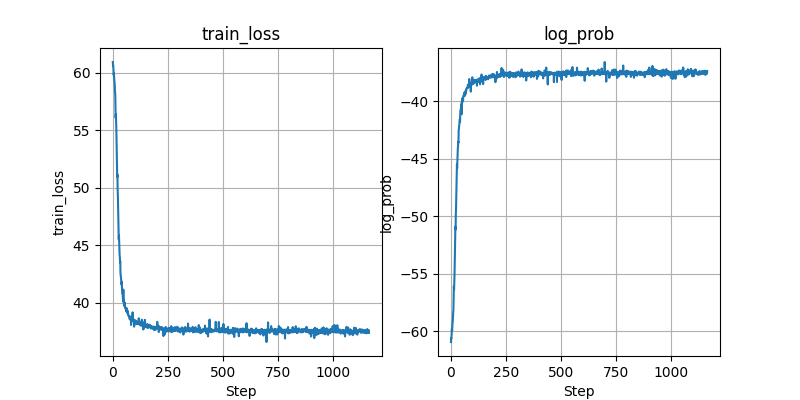

In [6]:
plot_logs(logger_unaware, columns=['train_loss', 'log_prob'])
logger_unaware.values['train_loss'][-1], logger_unaware.values['log_prob'][-1]

Train the oracle. The oracle is a causal flow that observes all the variables. Therefore, no hidden confounders are present.
This is the upper bound of performance.

In [ ]:
logger_oracle = MyLogger()
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,         
    patience=100,             
    verbose=False,
    mode='min'               
)
trainer_oracle = L.Trainer(callbacks=[early_stop_callback],max_epochs=epochs, logger=logger_oracle , enable_checkpointing=False, log_every_n_steps=len(train_loader)-1)
trainer_oracle.fit(oracle, all_train_loader, all_val_loader)

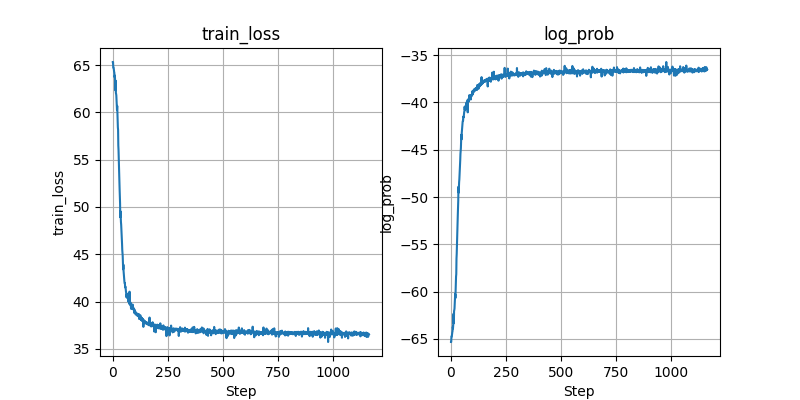

In [7]:
plot_logs(logger_oracle, columns=['train_loss', 'log_prob'])
logger_oracle.values['train_loss'][-1], logger_oracle.values['log_prob'][-1]

# Evaluate the models in the Identifiable direct paths

In [ ]:
# compare the performance in all green paths
green_paths = [('yceP', 'yfaD'),
               ('asnA', 'lacY'),
               ('lacA', 'lacY'),
               ('lacA', 'yaeM'),
               ('lacZ', 'yaeM'),
               ('yedE', 'pspA'),
               ('yedE', 'pspB')]
green_paths_indices = [(node_order.index(t), node_order.index(y)) for t, y in green_paths]


In [ ]:

from decaflow.utils.metrics import get_ate_error_multiple_paths, get_counterfactual_error_multiple_paths

df_ate_list = []
df_cf_list = []

decaflow_ate_error_green = get_ate_error_multiple_paths(decaflow, scm,
                                                        quantiles=[0.25, 0.75],
                                                        paths = green_paths_indices,
                                                        num_hidden=num_hidden,
                                                        train_data=train_data,
                                                        scm_scale=sigma,
                                                        scm_loc=mu)
decaflow_cf_error_green = get_counterfactual_error_multiple_paths(decaflow, scm,
                                                                   quantiles = [0.25, 0.75],
                                                                   paths = green_paths_indices,
                                                                   num_hidden=num_hidden,
                                                                   factual=test_data,
                                                                   train_data=train_data,
                                                                   scm_scale=sigma,
                                                                   scm_loc=mu)
decaflow_ate_error_green['model'] = 'decaflow'
decaflow_cf_error_green['model'] = 'decaflow'
df_ate_list.append(decaflow_ate_error_green)
df_cf_list.append(decaflow_cf_error_green)


In [ ]:
unaware_ate_error_green = get_ate_error_multiple_paths(unaware_flow, scm,
                                                        quantiles=[0.25, 0.75],
                                                        paths = green_paths_indices,
                                                        num_hidden=num_hidden,
                                                        train_data=train_data,
                                                        scm_scale=sigma,
                                                        scm_loc=mu)
unaware_cf_error_green = get_counterfactual_error_multiple_paths(unaware_flow, scm,
                                                                   quantiles = [0.25, 0.75],
                                                                   paths = green_paths_indices,
                                                                   num_hidden=num_hidden,
                                                                   factual=test_data,
                                                                   train_data=train_data,
                                                                   scm_scale=sigma,
                                                                   scm_loc=mu)
unaware_ate_error_green['model'] = 'unaware'
unaware_cf_error_green['model'] = 'unaware'
df_ate_list.append(unaware_ate_error_green)
df_cf_list.append(unaware_cf_error_green)


In [ ]:

oracle_ate_error_green = get_ate_error_multiple_paths(oracle, scm,
                                                        quantiles=[0.25, 0.75],
                                                        paths = green_paths_indices,
                                                        num_hidden=0,
                                                        train_data=train_data,
                                                        scm_scale=sigma,
                                                        scm_loc=mu)
oracle_cf_error_green = get_counterfactual_error_multiple_paths(oracle, scm,
                                                                   quantiles = [0.25, 0.75],
                                                                   paths = green_paths_indices,
                                                                   num_hidden=0,
                                                                   factual=test_data,
                                                                   train_data=train_data,
                                                                   scm_scale=sigma,
                                                                   scm_loc=mu)
oracle_ate_error_green['model'] = 'oracle'
oracle_cf_error_green['model'] = 'oracle'
df_ate_list.append(oracle_ate_error_green)
df_cf_list.append(oracle_cf_error_green)


In [ ]:
df_ate = pd.concat(df_ate_list, ignore_index=True)
df_cf = pd.concat(df_cf_list, ignore_index=True)

In [ ]:
df_ate.head()

In [ ]:
df_cf.head()

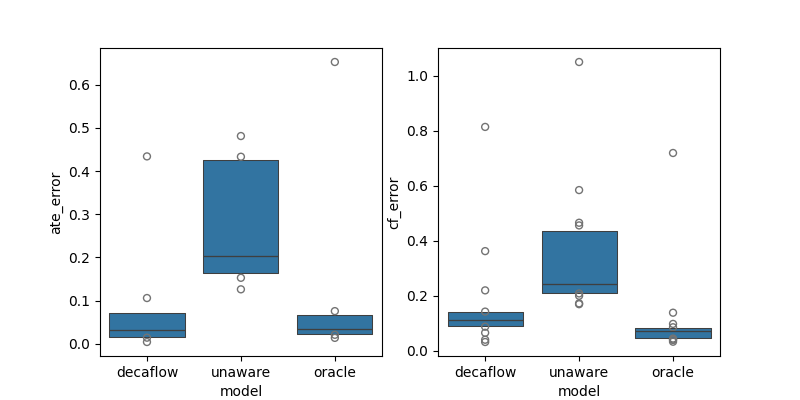

In [8]:
df_ate = pd.concat(df_ate_list, ignore_index=True)
df_cf = pd.concat(df_cf_list, ignore_index=True)

df_ate_melt = pd.melt(df_ate, id_vars='model', var_name='intervention', value_name='ate_error')
df_cf_melt = pd.melt(df_cf, id_vars='model', var_name='intervention', value_name='cf_error')

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ate_plot = sns.boxenplot(x='model', y='ate_error', data=df_ate_melt, ax=axs[0])
cf_plot = sns.boxenplot(x='model', y='cf_error', data=df_cf_melt, ax=axs[1])

plt.show()